(), scale=20, smoothness=1.3
CenteredGrid[(xˢ=64, yˢ=64), size=(x=100, y=100) int64, extrapolation=periodic]
2.3507513e-05


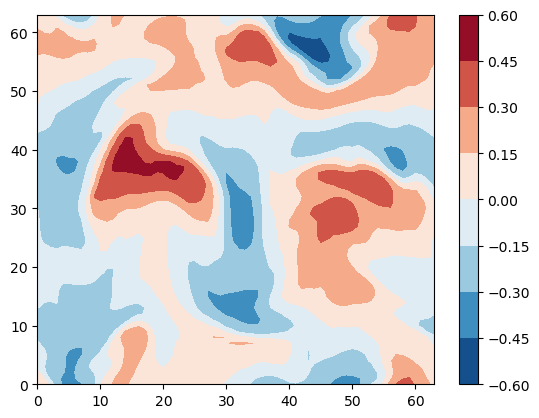

In [22]:
from phi.flow import *  # minimal dependencies
# from phi.torch.flow import *
# from phi.tf.flow import *
# from phi.jax.flow import *
import matplotlib.pyplot as plt

n=Noise(scale=20, smoothness=1.3)
print(n)
velocity = StaggeredGrid((0, 0), PERIODIC, x=64, y=64, bounds=Box(x=100, y=100))  # or CenteredGrid(...)
import numpy as np
from scipy.ndimage import gaussian_filter
n1=np.random.randn(40, 40)
n1=gaussian_filter(n1, sigma=2)
tnoise = tensor(n1, spatial('x,y'))
#nnpy=np.random.randn(200,200)
#smoke=CenteredGrid(nnpy, ZERO_GRADIENT, x=200, y=200, bounds=Box(x=100, y=100))
smoke1 = CenteredGrid(Noise(scale=20, smoothness=1.3), PERIODIC, x=64, y=64, bounds=Box(x=100, y=100))*0.2
#smoke2 = CenteredGrid(tnoise, ZERO_GRADIENT, x=40, y=40, bounds=Box(x=100, y=100))*0.2
smoke=0.975*smoke1#+0.25*smoke2
print(smoke)
INFLOW = 0.0 * resample(Sphere(x=50, y=9.5, radius=5), to=smoke, soft=True)
pressure = None


# @jit_compile  # Only for PyTorch, TensorFlow and Jax
def step(v, s, p, dt=1.):
    s = advect.mac_cormack(s, v, dt) + INFLOW
    buoyancy = resample(s * (0, 0.1), to=v)
    v = advect.semi_lagrangian(v, v, dt) + buoyancy * dt
    v, p = fluid.make_incompressible(v, (), Solve(x0=p))
    return v, s, p


#for _ in view(smoke, velocity, 'pressure', gui=None, play=False, namespace=globals()).range(warmup=1):
for _ in range(40):
    velocity, smoke, pressure = step(velocity, smoke, pressure)

smoke_np=(smoke.values.numpy('y,x'))
plt.contourf(smoke_np,cmap='RdBu_r')
plt.colorbar()
print(smoke_np.mean())

0.006270205


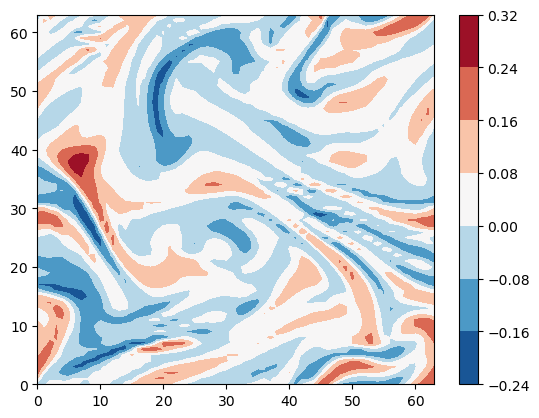

In [24]:
import matplotlib.pyplot as plt
dataL=[]
for _ in range(100):
    velocity, smoke, pressure = step(velocity, smoke, pressure)
    dataL.append([smoke.values.numpy('y,x'),velocity[0].values.numpy('y,x'),velocity[1].values.numpy('y,x'),pressure.values.numpy('y,x')])
smoke_np=(smoke.values.numpy('y,x'))
plt.contourf(smoke_np,cmap='RdBu_r')
plt.colorbar()
print(smoke_np.mean())
import pickle
pickle.dump(dataL, open( "smoke.pklz", "wb" ) )


In [25]:
dataL=np.array(dataL)
smoke=dataL[:,0,:,:]
velocity_u=dataL[:,1,:,:]
velocity_v=dataL[:,2,:,:]
pressure=dataL[:,3,:,:]

In [57]:
nt=dataL.shape[0]
xwindL=[]
ywindL=[]
for it in range(nt-5):
    x2d=np.zeros((24,24,4),float)
    y2d=np.zeros((8,8,4),float)
    for i in range(1,8-1):
        for j in range(1,8-1):
            x2d[:,:,0]=smoke[it,(i-1)*8:(i+2)*8,(j-1)*8:(j+2)*8]
            x2d[:,:,1]=velocity_u[it,(i-1)*8:(i+2)*8,(j-1)*8:(j+2)*8]
            x2d[:,:,2]=velocity_v[it,(i-1)*8:(i+2)*8,(j-1)*8:(j+2)*8]
            x2d[:,:,3]=pressure[it,(i-1)*8:(i+2)*8,(j-1)*8:(j+2)*8]
            y2d[:,:,0]=smoke[it+5,(i)*8:(i+1)*8,(j)*8:(j+1)*8]
            y2d[:,:,1]=velocity_u[it+5,(i)*8:(i+1)*8,(j)*8:(j+1)*8]
            y2d[:,:,2]=velocity_v[it+5,(i)*8:(i+1)*8,(j)*8:(j+1)*8]
            y2d[:,:,3]=pressure[it+5,(i)*8:(i+1)*8,(j)*8:(j+1)*8]
            xwindL.append(x2d)
            ywindL.append(y2d)
      


ValueError: could not broadcast input array from shape (24,24) into shape (8,8)

In [40]:
xwindL=np.array(xwindL)
xwind1D=xwindL.reshape(nt*8*8,64*4)
# import standard scaler 


(100, 8, 8, 256)


In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
xwin1D_t=scaler.fit_transform(xwind1D)

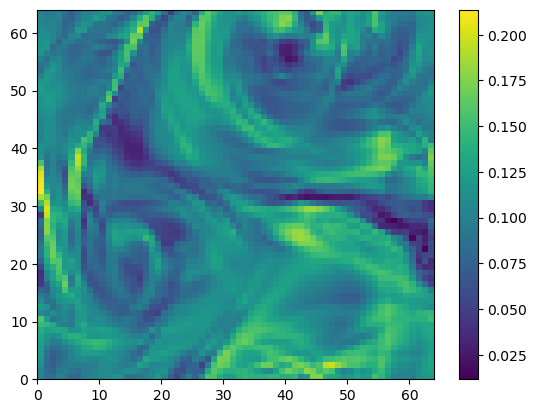

In [55]:
plt.pcolormesh(smoke.std(axis=0))
plt.colorbar()

In [48]:
# do PCA on the data
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
pca.fit(xwin1D_t)
print(pca.explained_variance_ratio_.sum())
xwin1D_t_pca=pca.transform(xwin1D_t)

0.9727150789096344


0.37703755


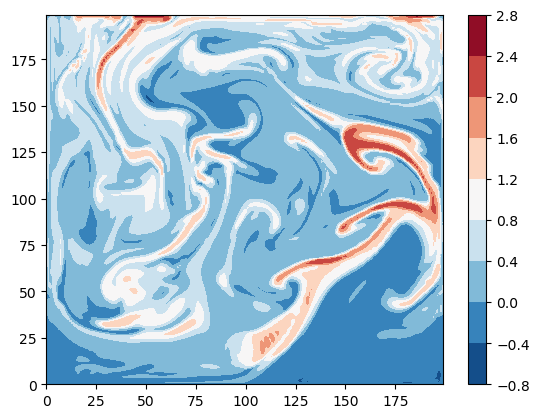

In [48]:
import matplotlib.pyplot as plt
import phi
#print(smoke)
for _ in range(10):
    velocity, smoke, pressure = step(velocity, smoke, pressure)
smoke_np=(smoke.values.numpy('y,x'))
plt.contourf(smoke_np,cmap='RdBu_r')
plt.colorbar()
print(smoke_np.mean())